## Import Packages

1. To build a recurrent neural network, we start by importing the Dense layer, Activation layer, and Loss function that you implemented in Lab4 & Flatten layer you implemented in Lab5. Ensure the following three files are located in the same directory as this notebook, and follow the instructions to complete the setup:
    - Dense.py : Copy the **Dense class** you had implemented in Lab4 to it.
    - Activation.py : Copy the **Activation class** you had implemented in Lab4 to it.
    - Loss.py : Copy **compute_CCE_loss** function you had implemented in Lab4 to it.
    - Flatten.py: Copy **Flatten class** you had implemented in Lab5 to it.\
    Note: you should copy both `forward()` and `backward()` in class `Flatten` in Lab5.


⚠️ **WARNING** ⚠️:
*   Please do not import any other packages in this lab.
*   np.random.seed(seed) is used to keep all the random function calls consistent. It will help us grade your work. Please don't change the seed.

❗ **Important** ❗: Please do not change the code outside this code bracket.
```
### START CODE HERE ###
...
### END CODE HERE ###
```



### Mount Google Drive (optional)

In [ ]:
### START CODE HERE ###
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('YOUR PATH')
### END CODE HERE ###

Mounted at /content/drive


In [1]:
###### import your Lab4 & Lab5 code (Don't change this part) ######
from Dense import Dense
from Activation import Activation
from Loss import compute_CCE_loss, compute_MSE_loss
from Flatten import Flatten
##################################

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

outputs = {}

# Basic Part

## RNN Class (30%)
The RNN class implements a simple Recurrent Neural Network (RNN) layer. This class includes methods for initializing parameters, performing the forward pass, computing gradients during the backward pass, and updating the weights.

Structure overview:
<figure> <img src="https://imgur.com/nU7xrBe.png" width="580" height="400">
</figure>
RNN connection:
<figure>
<img src="https://imgur.com/4JQX0se.png" width="500" height="250">
</figure>
Data insights:
<figure> <img src="https://imgur.com/c2MI3mj.png" width="400" height="220">
</figure>
In each neuron:
<figure> <img src="https://imgur.com/luXS4zv.png" width="300" height="220">
</figure>

1.   **Initializaon**

    *   `input_size`: The number of input features for each time step.
    *   `rnn_units`: The number of units (neurons) in the RNN layer.
    *   `seed`: A random seed for weight initialization to ensure reproducibility.

2.   **Initialize parameters** (3%)
    * `Wx`: The weight matrix for the input to hidden connections. It has a shape of `(rnn_units, input_size)`
    * `Wh`: The weight matrix for the hidden to hidden connections. It has a shape of `(rnn_units, rnn_units)`
    * `bh`: The bias vector for the hidden state. It has a shape of `(rnn_units, 1)`, where rnn_units is the number of units in the RNN layer.
3.  **Forward** (12%) \
* `X`: Input data of shape `(batch_size, timesteps, input_size)`
* The forward pass computes the hidden state `h_t` (shape of `(batch_size, self.rnn_units)`)at each time step `t` using the following formula:
$ h_t = \tanh(W_x \cdot x_t + W_h \cdot h_{t-1} + b_h)$
    * $W_x$ is the weight matrix for the input to hidden connections.
    * $W_h$ is the weight matrix for the hidden to hidden connections.
    * $b_h$ is the bias vector.
    * $x_t$ is the input at time step t.
    * $h_{t-1}$ is the hidden state from the previous time step.
    * $\tanh$ is the hyperbolic tangent activation function.
* Output would be shape of `(batch_size, rnn_units)`
4. **Backward** (15%) \
Reference (Backpropagation Through Time):
https://www.pycodemates.com/2023/08/backpropagation-through-time-explained-with-derivations.html
* `dH`: Gradient of the loss with respect to the hidden state, typically of shape `(batch_size, rnn_units, 1)`.
* The backward pass computes the gradients of the loss with respect to the weights and biases using the following formulas:
    * Gradient of the loss with respect to the hidden state(derivative of `tanh`):\
    $\delta_t = (1 - h_t^2) \cdot \delta_{t+1}$
        * $\delta_t$ is the gradient of the loss with respect to the hidden state at time step t.
        * $h_t$ is the hidden state at time step t
    * Gradients with respect to the weights and biases (accumulate the gradients over all time steps):
        1. $\frac{\partial L}{\partial W_x} = ∑_{t=0}^{timesteps} \delta_t^T \cdot x_t$
        2. $\frac{\partial L}{\partial W_h} = ∑_ {t=0}^{timesteps} \delta_t^T \cdot h_{t-1}$
        3. $\frac{\partial L}{\partial b_h} = ∑_{t=0}^{timesteps} \delta_t^T$
        * $\frac{\partial L}{\partial W_x}$ is the gradient of the loss with respect to the input to hidden weights.
        * $\frac{\partial L}{\partial W_h}$ is the gradient of the loss with respect to the hidden to hidden weights.
        * $\frac{\partial L}{\partial b_h}$ is the gradient of the loss with respect to the hidden bias.
        * $x_t$ is the input at time step t.
        * $h_{t-1}$ is the hidden state from the previous time step.
    * Gradient with respect to the previous hidden state:
    $\frac{\partial L}{\partial h_{t-1}} = \delta_t \cdot W_h$
    * Then divide each gradient by `batch_size`.
    * Gradient clipping (optional) is recommended in RNN since RNN rely on backpropagation through time where data might contain large timesteps and it might cause gradient explosion or vanishing. **Note**: You can't do gradient clipping in the function testing (`test_baward()`)


In [2]:
class RNN():
    def __init__(self, input_size, rnn_units, seed=1):
        """
        Initialize the SimpleRNN layer.

        Parameters:
        input_size (int): Number of input features.
        rnn_units (int): Number of units in the RNN layer.
        seed (int): Random seed for weight initialization.
        """
        self.input_size = input_size
        self.rnn_units = rnn_units
        self.seed = seed
        self.initialize_parameters()

    def initialize_parameters(self):
        """
        Initialize the weights and biases for the RNN layer.
        """
        np.random.seed(self.seed)

        ### START CODE HERE ###
        # Multiply by 0.01 is for testing reason.
        self.Wx = np.random.randn(self.rnn_units, self.input_size) * 0.01     # Input to hidden weights , with shape of (rnn_units, input_size).
        self.Wh = np.random.randn(self.rnn_units, self.rnn_units) * 0.01     # Hidden to hidden weights, with shape of (rnn_units, rnn_units).
        self.bh = np.zeros((self.rnn_units, 1))     # Hidden bias, with shape of (rnn_units, 1).
        ### END CODE HERE ###

    def forward(self, X):
        """
        Perform the forward pass through the RNN layer.

        Parameters:
        X (ndarray): Input data of shape (batch_size, timesteps, input_size).

        Returns:
        ndarray: Output of the RNN layer (hidden state).
        """
        batch_size, timesteps, _ = X.shape
        ### START CODE HERE ###
        self.h = np.zeros((batch_size, self.rnn_units))       # Initialize hidden state, with shape of (batch_size, self.rnn_units).
        self.hs = []      # Store hidden states for backward pass, list of self.h.
        ### END CODE HERE ###

        self.xs = []  # Store inputs for backward pass

        for t in range(timesteps):
            ### START CODE HERE ###
            x_t = X[:, t, :]              # Get input at time step t for all data in X.
            self.xs.append(x_t)
            self.h = np.tanh(self.Wx @ x_t.T + self.Wh @ self.h.T + self.bh).T           # Update hidden state according to the formula of h_t.
            self.hs.append(self.h)
            ### END CODE HERE ###

        return self.h


    def backward(self, dH):
        """
        Perform the backward pass through the RNN layer.

        Parameters:
        dH (ndarray): Gradient of the loss with respect to the hidden state.
        clip_value (float): Value to clip the gradients to prevent exploding gradients.

        Returns:
        ndarray: Gradient of the loss with respect to the input.
        """
        batch_size, _ = dH.shape
        ### START CODE HERE ###
        self.dL_dWx = np.zeros_like(self.Wx)        # Initialized with same shape as Wx.
        self.dL_dWh = np.zeros_like(self.Wh)        # Initialized with same shape as Wh.
        self.dL_dbh = np.zeros_like(self.bh)        # Initialized with same shape as bh.
        ### END CODE HERE ###
        dL_dh = dH

        for t in reversed(range(len(self.hs))):
            x_t = self.xs[t]  # Get input at time step t
            h = self.hs[t]
            h_prev = self.hs[t-1] if t > 0 else np.zeros_like(h)
            ### START CODE HERE ###
            dL_dh_raw = (1 - (h**2)) * dL_dh     # Derivative of tanh
            self.dL_dWx = self.dL_dWx + (dL_dh_raw.T @ x_t)   # Gradient w.r.t. Wx
            self.dL_dWh = self.dL_dWh + (dL_dh_raw.T @ h_prev)   # Gradient w.r.t. Wh
            self.dL_dbh = self.dL_dbh + np.sum(dL_dh_raw, axis=0, keepdims=True).T   # Gradient w.r.t. bh
            dL_dh = dL_dh_raw @ self.Wh         # Gradient w.r.t. previous hidden state (Wh)
            ### END CODE HERE ###

        ### START CODE HERE ###
        # Average gradients over the batch.
        self.dL_dWx = self.dL_dWx / batch_size
        self.dL_dWh = self.dL_dWh / batch_size
        self.dL_dbh = self.dL_dbh / batch_size
        ### END CODE HERE ###

        ### START CODE HERE ###
        # Gradient part (optional), you can't run this part while testing the backward function !!!
        clip_value = 2.0
        # Clip gradients to prevent exploding gradients
        np.clip(self.dL_dWx, -clip_value, clip_value, out=self.dL_dWx)
        np.clip(self.dL_dWh, -clip_value, clip_value, out=self.dL_dWh)
        np.clip(self.dL_dbh, -clip_value, clip_value, out=self.dL_dbh)
        ### END CODE HERE ###

        return dL_dh

    def update(self, learning_rate):
        """
        Update the weights and biases using the computed gradients.

        Parameters:
        learning_rate (float): Learning rate for weight updates.
        """
        ### START CODE HERE ###
        # Update each weights.
        self.Wx = self.Wx - learning_rate * self.dL_dWx
        self.Wh = self.Wh - learning_rate * self.dL_dWh
        self.bh = self.bh - learning_rate * self.dL_dbh
        ### END CODE HERE ###

### Functions testing


#### `initialize_parameter` function

In [3]:
def test_initialization(save_to_output = False):
    input_size = 5
    rnn_units = 3
    rnn = RNN(input_size, rnn_units)
    print("Wx shape:", rnn.Wx.shape)
    print("Wh shape:", rnn.Wh.shape)
    print("bh shape:", rnn.bh.shape)
    if save_to_output == True:
        outputs['RNN_initialization'] = {"Wx shape": rnn.Wx.shape, "Wh shape": rnn.Wh.shape, "bh shape": rnn.bh.shape}
test_initialization(True)

Wx shape: (3, 5)
Wh shape: (3, 3)
bh shape: (3, 1)


Expected output:

|Output|Value|
|---|---|
|Wx shape:|(3, 5)|
|Wh shape:|(3, 3)|
|bh shape:|(3, 1)|

#### `forward` function


In [4]:
def test_forward(seed, save_to_output = False):
    input_size = 5
    rnn_units = 3
    batch_size = 2
    timesteps = 4
    # Initialize the RNN layer
    rnn = RNN(input_size, rnn_units)
    # Create a sample input of shape (batch_size, timesteps, input_size)
    np.random.seed(seed)   # Don't change the seed!
    X = np.random.randn(batch_size, timesteps, input_size)
    # Perform the forward pass
    output = rnn.forward(X)

    if save_to_output == False:
        # Print the output
        print("Input shape:", X.shape)
        print("Input:")
        print(X)
        print("Output shape of RNN layer:", output.shape)
        print("Output of the RNN layer (hidden state):")
        print(output)

    if save_to_output == True:
        outputs['RNN_forward'] = {"X shape": X.shape, "X": X, "Output shape": output.shape, "Output": output}

# Run the test with seed 1 to compare with expected outputs.
test_forward(1)

# Run with seed 42 and save the answer.
test_forward(42, True)

Input shape: (2, 4, 5)
Input:
[[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
  [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
  [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]
  [-1.09989127 -0.17242821 -0.87785842  0.04221375  0.58281521]]

 [[-1.10061918  1.14472371  0.90159072  0.50249434  0.90085595]
  [-0.68372786 -0.12289023 -0.93576943 -0.26788808  0.53035547]
  [-0.69166075 -0.39675353 -0.6871727  -0.84520564 -0.67124613]
  [-0.0126646  -1.11731035  0.2344157   1.65980218  0.74204416]]]
Output shape of RNN layer: (2, 3)
Output of the RNN layer (hidden state):
[[-0.00873835  0.02641052 -0.00287992]
 [-0.00596289 -0.01742189  0.02418844]]


Expected output of `forward`:

| Output | Value |
|---|---|
| Input shape | (2, 4, 5) |
| Input | `[[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]`<br>  `[-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]`<br>  `[ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]`<br>  `[-1.09989127 -0.17242821 -0.87785842  0.04221375  0.58281521]]`<br><br> `[[-1.10061918  1.14472371  0.90159072  0.50249434  0.90085595]`<br>  `[-0.68372786 -0.12289023 -0.93576943 -0.26788808  0.53035547]`<br>  `[-0.69166075 -0.39675353 -0.6871727  -0.84520564 -0.67124613]`<br>  `[-0.0126646  -1.11731035  0.2344157   1.65980218  0.74204416]]]]` |
| Output shape of RNN layer | (2, 3) |
| Output of the RNN layer (hidden state) | `[[-0.00873835  0.02641052 -0.00287992]`<br> `[-0.00596289 -0.01742189  0.02418844]]` |

#### `backward` function

In [5]:
def test_backward(seed, save_to_output = False):
    input_size = 5
    rnn_units = 3
    batch_size = 2
    timesteps = 4

    # Initialize the RNN layer
    rnn = RNN(input_size, rnn_units)
    np.random.seed(seed)   # Don't change the seed!
    # Create a sample input of shape (batch_size, timesteps, input_size)
    X = np.random.randn(batch_size, timesteps, input_size)
    # Perform the forward pass
    rnn.forward(X)
    # Create a sample gradient of the loss with respect to the hidden state
    dH = np.random.randn(batch_size, rnn_units)
    # Perform the backward pass
    dL_dX = rnn.backward(dH)
    if save_to_output == False:
        print("dH shape: ", dH.shape)
        print("dH:")
        print(dH)
        # Print the gradients
        print("dL_dX shape:", dL_dX.shape)
        print("Gradient w.r.t. input (dL_dX):")
        print(dL_dX)
        print("dL_dWx shape:", rnn.dL_dWx.shape)
        print("Gradient w.r.t. Wx (dL_dWx):")
        print(rnn.dL_dWx)
        print("dL_dWh shape:", rnn.dL_dWh.shape)
        print("Gradient w.r.t. Wh (dL_dWh):")
        print(rnn.dL_dWh)
        print("dL_dbh shape:", rnn.dL_dbh.shape)
        print("Gradient w.r.t. bh (dL_dbh):")
        print(rnn.dL_dbh)

    if save_to_output == True:
        outputs['RNN_backward'] = {"dH shape": dH.shape, "dH": dH, "dL_dX shape": dL_dX.shape, "dL_dX": dL_dX, "dL_dWx shape": rnn.dL_dWx.shape,
                                   "dL_dWx": rnn.dL_dWx, "dL_dWh shape": rnn.dL_dWh.shape, "dL_dWh": rnn.dL_dWh, "dL_dbh shape": rnn.dL_dbh.shape, "dL_dbh": rnn.dL_dbh}

# Run the test with seed 1 to compare with expected outputs.
test_backward(1)

# Run with seed 42 and save the answer.
test_backward(42, True)

dH shape:  (2, 3)
dH:
[[-0.19183555 -0.88762896 -0.74715829]
 [ 1.6924546   0.05080775 -0.63699565]]
dL_dX shape: (2, 3)
Gradient w.r.t. input (dL_dX):
[[-1.30293142e-08  5.55316892e-09 -2.93987480e-08]
 [ 8.78019041e-09  2.41595285e-08 -1.33357681e-08]]
dL_dWx shape: (3, 5)
Gradient w.r.t. Wx (dL_dWx):
[[ 0.09855041 -0.91665683  0.29245483  1.41272981  0.57684949]
 [ 0.48200032  0.06164319  0.40009246  0.02920006 -0.24340623]
 [ 0.42661386  0.4160692   0.25830352 -0.53769917 -0.44331323]]
dL_dWh shape: (3, 3)
Gradient w.r.t. Wh (dL_dWh):
[[-0.00663169  0.01738478 -0.0106337 ]
 [-0.02325593  0.03069429 -0.03469078]
 [-0.01936184  0.02200992 -0.02853306]]
dL_dbh shape: (3, 1)
Gradient w.r.t. bh (dL_dbh):
[[ 0.73406116]
 [-0.42812618]
 [-0.69714697]]


Expected output:

| Output | Value |
|---|---|
|dH shape:|(2, 3)|
|dH:|`[[-0.19183555 -0.88762896 -0.74715829]`<br>`[ 1.6924546   0.05080775 -0.63699565]]`|
|dL_dX shape:| (2, 3)|
|Gradient w.r.t. input (dL_dX):| `[[-1.30293142e-08  5.55316892e-09 -2.93987480e-08]`<br>`[ 8.78019041e-09  2.41595285e-08 -1.33357681e-08]]`|
|dL_dWx shape:| (3, 5)|
|Gradient w.r.t. Wx (dL_dWx):|`[[ 0.09855041 -0.91665683  0.29245483  1.41272981  0.57684949]`<br>`[ 0.48200032  0.06164319  0.40009246  0.02920006 -0.24340623]`<br>`[ 0.42661386  0.4160692   0.25830352 -0.53769917 -0.44331323]]`|
|dL_dWh shape:| (3, 3)|
|Gradient w.r.t. Wh (dL_dWh):|`[[-0.00663169  0.01738478 -0.0106337 ]`<br>`[-0.02325593  0.03069429 -0.03469078]`<br>`[-0.01936184  0.02200992 -0.02853306]]`|
|dL_dbh shape:| (3, 1)|
|Gradient w.r.t. bh (dL_dbh):|`[[ 0.73406116]`<br>`[-0.42812618]`<br>`[-0.69714697]]`|

## Model class (10%)
The `Model` class provides a framework for building and training neural networks.
1.   `add()` is just like the function in previous Lab, we can call `model.add( )` to sequentially add a layer into the model.
2.   `forward()` performs the forward propagation of data through the layers, calculating predictions
3.   In `backward()`, we have to check if the activation function is *softmax* to make sure we call the right `backward()`.
4.   `train()` function will be used to train the model, here, we can decide which loss function `BCE` or `MSE` we want to train with. And also calculate the loss for validation data.
5. `plot_losses()` function can show the history of the training and validation loss to see if the training works.

In [6]:
class Model():
    def __init__(self):
        self.layers = []

    def add(self, layer):
        """
        Sequentially add a layer into the model.

        Parameters:
        layer: Different layers class.
        """
        ### START CODE HERE ###
        self.layers.append(layer)
        ### END CODE HERE ###

    def forward(self, X):
        for layer in self.layers:
            if layer.__class__.__name__ == 'RNN':
                if len(X.shape) < 3:                                # If the RNN layer is stacked after another RNN layer.
                    ### START CODE HERE ###
                    X = np.expand_dims(X, axis = 1)                 # We have to treat the output size of first layer (rnn_units) as the feature size (input_size) of the second layer.
                    ### END CODE HERE ###
                X = layer.forward(X)
            else:
                X = layer.forward(X)
        return X

    def backward(self, dA, Y):
        for layer in reversed(self.layers):
            if isinstance(layer, Activation) and layer.activation_function == "softmax":
                ### START CODE HERE ###
                dA = layer.backward(dA, Y)                   # softmax activation backward.
                ### END CODE HERE ###
            else:
                ### START CODE HERE ###
                dA = layer.backward(dA)
                ### END CODE HERE ###
        return dA

    def update(self, learning_rate):
        for layer in self.layers:       # Update for every layers.
            ### START CODE HERE ###
            if hasattr(layer, 'update'):
                layer.update(learning_rate)
            ### END CODE HERE ###

    def train(self, X_train, y_train, X_val, y_val, epochs=10, learning_rate=0.001, batch_size = 32, loss_function='mse'):
        self.train_losses = []  # Initialize a list to store training losses
        self.val_losses = []  # Initialize a list to store validation losses
        for epoch in range(epochs):
            total_loss = 0
            ### START CODE HERE ###
            num_batches = int(np.ceil(len(X_train) / batch_size))    # Calculate the number of batches
            ### END CODE HERE ###

            with tqdm(total=num_batches, desc=f"Epoch {epoch + 1}/{epochs}", unit="batch") as pbar:
                for batch_idx in range(num_batches):

                    ### START CODE HERE ###
                    # Get the batch data
                    X_batch = X_train[batch_idx * batch_size : (batch_idx + 1) * batch_size]
                    y_batch = y_train[batch_idx * batch_size : (batch_idx + 1) * batch_size]
                    ### END CODE HERE ###

                    ### START CODE HERE ###
                    # 1. Forward to get the prediction.
                    # 2. Calculate the loss according to your parameters ('cce' or 'mse').
                    # 3. Calculate dA.
                    # 4. backward with the calculated dA.
                    # 5. update the parameters.
                    y_pred = self.forward(X_batch)
                    # Compute loss
                    if loss_function == 'cce':
                        loss = compute_CCE_loss(y_pred, y_batch)
                        dA = y_pred - y_batch
                    elif loss_function == 'mse':
                        loss = compute_MSE_loss(y_pred, y_batch)
                        dA = 2 * (y_pred - y_batch) / y_pred.shape[0]
                    else:
                        raise ValueError("Unsupported loss function")

                    total_loss += loss
                    self.backward(dA, y_batch)
                    self.update(learning_rate)
                    ### END CODE HERE ###

                    # Update the progress bar and loss every 5 iterations
                    if (batch_idx + 1) % 5 == 0:
                        pbar.set_postfix(loss=total_loss / (batch_idx + 1))
                    pbar.update(1)  # Increment the progress bar by 1 unit

                # Handle the remaining examples that do not fit into a full batch
                if len(X_train) % batch_size != 0:

                    # Get the remaining data
                    ### START CODE HERE ###
                    X_batch = X_train[-batch_size:]
                    y_batch = y_train[-batch_size:]
                    ### END CODE HERE ###

                    ### START CODE HERE ###
                    # Same as above in batch
                    y_pred = self.forward(X_batch)
                    # Compute loss
                    if loss_function == 'cce':
                        loss = compute_CCE_loss(y_pred, y_batch)
                    elif loss_function == 'mse':
                        loss = compute_MSE_loss(y_pred, y_batch)
                    else:
                        raise ValueError("Unsupported loss function")

                    total_loss += loss
                    self.backward(y_pred, y_batch)
                    self.update(learning_rate)
                    ### END CODE HERE ###

            ### START CODE HERE ###
            avg_train_loss = total_loss / num_batches       # Calculate the average loss over batches.
            ### END CODE HERE ###

            self.train_losses.append(avg_train_loss)
            print(f'Epoch {epoch + 1}/{epochs}, Training Loss: {avg_train_loss}')

            # Validation part
            ### START CODE HERE ###
            # 1. Get the prediction
            # 2. compute the loss ('mse', 'cce').
            y_pred = self.forward(X_val)

            if loss_function == 'cce':
                val_loss = compute_CCE_loss(y_pred, y_val)
            elif loss_function == 'mse':
                val_loss = compute_MSE_loss(y_pred, y_val)
            ### END CODE HERE ###

            self.val_losses.append(val_loss)
            print(f'Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss}')

    def predict(self, X):
        return self.forward(X)

    def plot_losses(self):
        plt.plot(self.train_losses, label='Training Loss')
        plt.plot(self.val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

### `Model` class testing

In [7]:
def test_model_class(seed, save_to_output = False):
    np.random.seed(seed)
    input = np.random.randn(3, 3, 1)
    Y = np.expand_dims(np.array([1,0,1]),-1)

    model = Model()
    model.add(RNN(1, 4))
    model.add(RNN(4, 4))
    model.add(Dense(4, 1))
    model.add(Activation("sigmoid", None))

    AL = model.forward(input)
    dA_prev = model.backward(AL, Y=Y)
    model.update(0.1)
    if save_to_output == False:
        print("AL: ", AL)
        print("dA_prev: ", dA_prev)
        print("Wx of RNN: ", model.layers[0].Wx)
        print("Wh of RNN: ", model.layers[0].Wh)
        print("bh of RNN: ", model.layers[0].bh)

    if save_to_output == True:
        outputs['Model_class'] = {"AL": AL, "dA_prev": dA_prev, "Wx of RNN": model.layers[0].Wx, "Wh of RNN": model.layers[0].Wh, "bh of RNN": model.layers[0].bh}

# Run the test with seed 1 to compare with expected outputs.
test_model_class(1)

# Run with seed 42 and save the answer.
test_model_class(42, True)

AL:  [[0.50002597]
 [0.50011082]
 [0.49998505]]
dA_prev:  [[ 1.62378331e-09  3.84694676e-09  6.02625343e-09 -1.21805669e-08]
 [ 1.62165475e-09  3.84752280e-09  6.02247634e-09 -1.21748332e-08]
 [ 1.62368851e-09  3.84622277e-09  6.02587086e-09 -1.21793784e-08]]
Wx of RNN:  [[ 0.01609996]
 [-0.00598851]
 [-0.00519148]
 [-0.01059058]]
Wh of RNN:  [[ 0.00865366 -0.02301519  0.01744827 -0.00761178]
 [ 0.00319076 -0.00249388  0.01462095 -0.02060167]
 [-0.00322391 -0.00384067  0.0113376  -0.0109991 ]
 [-0.00172383 -0.00877879  0.00042198  0.00582784]]
bh of RNN:  [[ 0.00017288]
 [-0.00015564]
 [-0.00010827]
 [-0.00016452]]


Expected output:

|Output|Value|
|---|---|
|AL:| `[[0.50002597]`<br>`[0.50011082]`<br>`[0.49998505]]`|
|dA_prev:|`[[ 1.62378331e-09  3.84694676e-09  6.02625343e-09 -1.21805669e-08]`<br>`[ 1.62165475e-09  3.84752280e-09  6.02247634e-09 -1.21748332e-08]`<br>`[ 1.62368851e-09  3.84622277e-09  6.02587086e-09 -1.21793784e-08]]`|
|Wx of RNN:| `[[ 0.01609996]`<br>`[-0.00598851]`<br>`[-0.00519148]`<br>`[-0.01059058]]`|
|Wh of RNN:|`[[ 0.00865366 -0.02301519  0.01744827 -0.00761178]`<br>`[ 0.00319076 -0.00249388  0.01462095 -0.02060167]`<br>`[-0.00322391 -0.00384067  0.0113376  -0.0109991 ]`<br>`[-0.00172383 -0.00877879  0.00042198  0.00582784]]`|
|bh of RNN:|  `[[ 0.00017288]`<br>`[-0.00015564]`<br>`[-0.00010827]`<br>`[-0.00016452]]`|

### Save the above output to `.npy`

In [8]:
assert list(outputs.keys()) == ['RNN_initialization', 'RNN_forward', 'RNN_backward', 'Model_class']
np.save('Lab6_outputs.npy', outputs)
# sanity check for saved outputs
submit = np.load("Lab6_outputs.npy", allow_pickle=True).item()
for key, value in submit.items():
    if isinstance(value, dict):  # Check if value is a dictionary
        print(f"{key}:")
        for inner_key, inner_value in value.items():
            print(f"  {inner_key}: {type(inner_value)}")  # Print type of inner values
    else:
        print(f"{key}: {type(value)}")  # Print type of other values

RNN_initialization:
  Wx shape: <class 'tuple'>
  Wh shape: <class 'tuple'>
  bh shape: <class 'tuple'>
RNN_forward:
  X shape: <class 'tuple'>
  X: <class 'numpy.ndarray'>
  Output shape: <class 'tuple'>
  Output: <class 'numpy.ndarray'>
RNN_backward:
  dH shape: <class 'tuple'>
  dH: <class 'numpy.ndarray'>
  dL_dX shape: <class 'tuple'>
  dL_dX: <class 'numpy.ndarray'>
  dL_dWx shape: <class 'tuple'>
  dL_dWx: <class 'numpy.ndarray'>
  dL_dWh shape: <class 'tuple'>
  dL_dWh: <class 'numpy.ndarray'>
  dL_dbh shape: <class 'tuple'>
  dL_dbh: <class 'numpy.ndarray'>
Model_class:
  AL: <class 'numpy.ndarray'>
  dA_prev: <class 'numpy.ndarray'>
  Wx of RNN: <class 'numpy.ndarray'>
  Wh of RNN: <class 'numpy.ndarray'>
  bh of RNN: <class 'numpy.ndarray'>


Expected output:


```
RNN_initialization:
  Wx shape: <class 'tuple'>
  Wh shape: <class 'tuple'>
  bh shape: <class 'tuple'>
RNN_forward:
  X shape: <class 'tuple'>
  X: <class 'numpy.ndarray'>
  Output shape: <class 'tuple'>
  Output: <class 'numpy.ndarray'>
RNN_backward:
  dH shape: <class 'tuple'>
  dH: <class 'numpy.ndarray'>
  dL_dX shape: <class 'tuple'>
  dL_dX: <class 'numpy.ndarray'>
  dL_dWx shape: <class 'tuple'>
  dL_dWx: <class 'numpy.ndarray'>
  dL_dWh shape: <class 'tuple'>
  dL_dWh: <class 'numpy.ndarray'>
  dL_dbh shape: <class 'tuple'>
  dL_dbh: <class 'numpy.ndarray'>
Model_class:
  AL: <class 'numpy.ndarray'>
  dA_prev: <class 'numpy.ndarray'>
  Wx of RNN: <class 'numpy.ndarray'>
  Wh of RNN: <class 'numpy.ndarray'>
  bh of RNN: <class 'numpy.ndarray'>
```



## Sinusoidal wave dataset (20%)
In this section, we will generate a dataset of sinusoidal waves with varying frequencies, amplitudes, and random phase shifts. The **last value** in each sequence will be used as the target prediction. This dataset will be used for training and validating a model.



*   You can decide how many `num_samples`, `num_timesteps`, `freq_range` and `amp_range` you want to generate your own training dataset. (**there is no provided training dataset!**)
* ⚠⚠ You need to download X_test.csv from Kaggle and put it into Sinewave directory. (Or you have to change the path when generating prediction)
* For **testing data** on Kaggle, we used `num_timesteps = 100`, `0.5 <= freq_range <= 5` & `0.5 <= amp_range <= 5` to generate, your training dataset can try to cover these range in testing data.
* You need submit the `y_test.csv` to Kaggle
    * `MAPE <= 17%` -> 10 points
    * `MAPE <= 14%` -> 20 points
* **Kaggle Link**: https://www.kaggle.com/t/512f44fe285d4c1bb90c39884f8a2a33

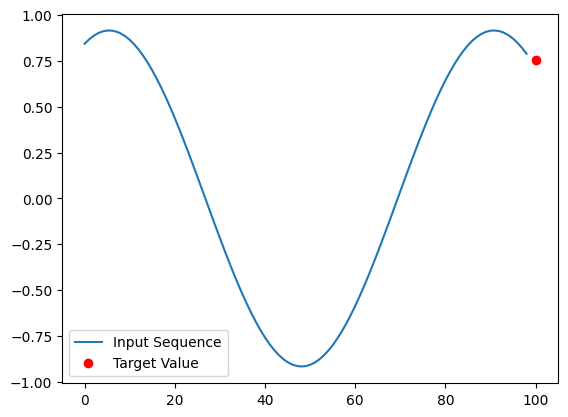

In [ ]:
  # Generate Sinusoidal Wave Dataset

  def generate_sine_wave_data(num_samples, num_timesteps, freq_range, amp_range):
      """
      Generate sine wave data with varying frequencies, amplitudes, and random phase shifts.
      The last value in each sequence is used as the target prediction.

      Parameters:
      - num_samples: Number of samples to generate.
      - num_timesteps: Number of timesteps for each sample.
      - freq_range: Tuple of floor and ceiling of frequency range.
      - amp_range: Tuple of floor and ceiling of amplitude range.

      Returns:
      - X: Generated sine wave data of shape (num_samples, num_timesteps - 1).
      - y: Target values of shape (num_samples,).
      """
      X = np.zeros((num_samples, num_timesteps - 1))
      y = np.zeros(num_samples)
      for i in range(num_samples):
          ### START CODE HERE ###
          # Choose the frequency, amplitude and shift phase value.
          freq = np.random.uniform(*freq_range)             # Random choose from freq_range.
          amp = np.random.uniform(*amp_range)              # Random choose from amp_range.
          phase_shift = np.random.uniform(0, 2*np.pi)      # Random choose from (0, 2*pi).
          ### END CODE HERE ###

          t = np.linspace(0, 2 * np.pi, num_timesteps)
          sine_wave = amp * np.sin(freq * t + phase_shift)
          X[i] = sine_wave[:-1]  # All but the last value
          y[i] = sine_wave[-1]   # The last value
      return X, y

  ### START CODE HERE ###
  # You can modify to your preferred range and number of samples. (Note: It's recommended to cover the range of testing data mentioned above.)
  num_samples = 50000
  num_timesteps = 100
  freq_range = (0.5, 5.0)  # Frequency range
  amp_range = (0.5, 5.0)   # Amplitude range
  ### END CODE HERE ###

  X, y = generate_sine_wave_data(num_samples, num_timesteps, freq_range, amp_range)

  ### START CODE HERE ###
  # Split data into training and validation sets
  split_ratio = 0.8
  split_index = int(num_samples * split_ratio)
  X_train, X_val = X[:split_index], X[split_index:]
  y_train, y_val = y[:split_index], y[split_index:]
  ### END CODE HERE ###

  # Plot an example sequence
  plt.plot(X_train[0], label='Input Sequence')
  plt.plot(np.arange(num_timesteps, num_timesteps + 1), y_train[0], 'ro', label='Target Value')
  plt.legend()
  plt.show()


### Construct the model with Dense layer only
Here, we want you to construct the model with **Dense layer only** like you did in Lab4. You may modify the model structure and parameters in the way you like.

Epoch 1/20: 100%|██████████| 1250/1250 [00:01<00:00, 915.67batch/s, loss=0.477]


Epoch 1/20, Training Loss: 0.4765526677668221
Epoch 1/20, Validation Loss: 0.08834466783524401


Epoch 2/20: 100%|██████████| 1250/1250 [00:01<00:00, 758.06batch/s, loss=0.0663]


Epoch 2/20, Training Loss: 0.06634148030135449
Epoch 2/20, Validation Loss: 0.04977560541016737


Epoch 3/20: 100%|██████████| 1250/1250 [00:01<00:00, 885.20batch/s, loss=0.0412]


Epoch 3/20, Training Loss: 0.04118845275740444
Epoch 3/20, Validation Loss: 0.0340600831984253


Epoch 4/20: 100%|██████████| 1250/1250 [00:01<00:00, 941.59batch/s, loss=0.03]


Epoch 4/20, Training Loss: 0.03001132700312364
Epoch 4/20, Validation Loss: 0.026313223341932868


Epoch 5/20: 100%|██████████| 1250/1250 [00:01<00:00, 918.96batch/s, loss=0.0242]


Epoch 5/20, Training Loss: 0.02415298946361864
Epoch 5/20, Validation Loss: 0.021869051194836175


Epoch 6/20: 100%|██████████| 1250/1250 [00:01<00:00, 902.34batch/s, loss=0.0205]


Epoch 6/20, Training Loss: 0.02050867075043932
Epoch 6/20, Validation Loss: 0.018878958583996026


Epoch 7/20: 100%|██████████| 1250/1250 [00:01<00:00, 890.72batch/s, loss=0.0179]


Epoch 7/20, Training Loss: 0.017887190436804902
Epoch 7/20, Validation Loss: 0.016604149764033346


Epoch 8/20: 100%|██████████| 1250/1250 [00:01<00:00, 926.16batch/s, loss=0.0158]


Epoch 8/20, Training Loss: 0.015821450581559808
Epoch 8/20, Validation Loss: 0.014777454019165484


Epoch 9/20: 100%|██████████| 1250/1250 [00:01<00:00, 930.74batch/s, loss=0.0141]


Epoch 9/20, Training Loss: 0.014116894722901582
Epoch 9/20, Validation Loss: 0.013236120544203226


Epoch 10/20: 100%|██████████| 1250/1250 [00:01<00:00, 946.70batch/s, loss=0.0127]


Epoch 10/20, Training Loss: 0.012670623732139312
Epoch 10/20, Validation Loss: 0.0119253650967438


Epoch 11/20: 100%|██████████| 1250/1250 [00:01<00:00, 647.27batch/s, loss=0.0114]


Epoch 11/20, Training Loss: 0.011434616704437857
Epoch 11/20, Validation Loss: 0.010803755715529531


Epoch 12/20: 100%|██████████| 1250/1250 [00:01<00:00, 653.59batch/s, loss=0.0104]


Epoch 12/20, Training Loss: 0.010370834028523493
Epoch 12/20, Validation Loss: 0.009837374480194996


Epoch 13/20: 100%|██████████| 1250/1250 [00:01<00:00, 802.30batch/s, loss=0.00945]


Epoch 13/20, Training Loss: 0.009448742112912321
Epoch 13/20, Validation Loss: 0.008995112292426789


Epoch 14/20: 100%|██████████| 1250/1250 [00:01<00:00, 745.15batch/s, loss=0.00865]


Epoch 14/20, Training Loss: 0.008646543921457299
Epoch 14/20, Validation Loss: 0.008264001478415307


Epoch 15/20: 100%|██████████| 1250/1250 [00:01<00:00, 885.24batch/s, loss=0.00795]


Epoch 15/20, Training Loss: 0.007946052840209416
Epoch 15/20, Validation Loss: 0.007626069455277409


Epoch 16/20: 100%|██████████| 1250/1250 [00:01<00:00, 880.07batch/s, loss=0.00733]


Epoch 16/20, Training Loss: 0.007334707174630663
Epoch 16/20, Validation Loss: 0.0070700867271254126


Epoch 17/20: 100%|██████████| 1250/1250 [00:01<00:00, 886.68batch/s, loss=0.0068]


Epoch 17/20, Training Loss: 0.006800046828231216
Epoch 17/20, Validation Loss: 0.0065840251891835224


Epoch 18/20: 100%|██████████| 1250/1250 [00:01<00:00, 894.11batch/s, loss=0.00633]


Epoch 18/20, Training Loss: 0.006332349321098221
Epoch 18/20, Validation Loss: 0.006157838744714556


Epoch 19/20: 100%|██████████| 1250/1250 [00:01<00:00, 892.19batch/s, loss=0.00592]


Epoch 19/20, Training Loss: 0.005921718052816317
Epoch 19/20, Validation Loss: 0.0057852515308248415


Epoch 20/20: 100%|██████████| 1250/1250 [00:01<00:00, 930.61batch/s, loss=0.00556]


Epoch 20/20, Training Loss: 0.005563854526603097
Epoch 20/20, Validation Loss: 0.005456560453158669


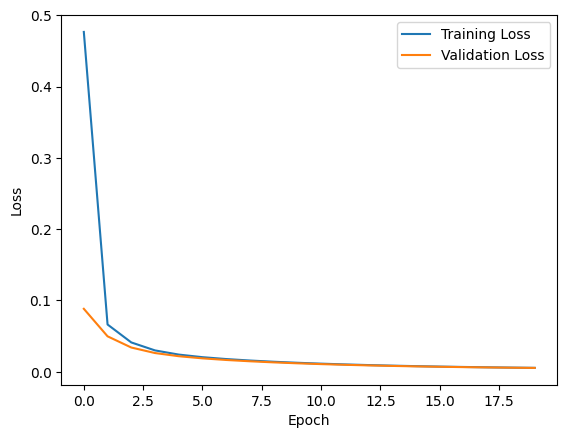

In [ ]:
### START CODE HERE ###
# Change the structure and parameters to train your own model (Only contain Dense layer here!!!)
# Reshape the input data to fit Dense model
input_size = X_train.shape[1]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1])
y_val = y_val.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)
# Construct the model with Dense layers

model = Model()
model.add(Dense(input_size, 64))
model.add(Activation("relu", None))
model.add(Dense(64, 1))
model.add(Activation("linear", None))

# Train the model
model.train(X_train, y_train, X_val, y_val, epochs=20, learning_rate=0.02, batch_size = 32, loss_function='mse')
### END CODE HERE ###

# Plot the training and validation losses
model.plot_losses()

#### Predict testing data & Save the answer (For Dense model)
For this prediction of Dense model, you can choose not to submit it to Kaggle if its performance is not better.

In [ ]:
### START CODE HERE ###
# Read the X_test.csv file into a DataFrame
# Change the path if needed
# download
X_test_df = pd.read_csv('X_test.csv')
### END CODE HERE ###

# Do not modify this part to get the correct output format!!
# Drop the 'Id' column if it exists
if 'Id' in X_test_df.columns:
    X_test_df = X_test_df.drop(columns=['Id'])

# Convert the DataFrame to a numpy array
X_test = X_test_df.values
y_pred = model.predict(X_test)


# Convert the list of predictions to a numpy array
y_pred = np.array(y_pred)
y_pred_df = pd.DataFrame(y_pred, columns=['answer'])
y_pred_df.insert(0, 'Id', range(1, 1 + len(y_pred_df)))
y_pred_df.to_csv('y_pred_basic.csv', index=False)

print('Prediction data has been saved.')

Prediction data has been saved.


### Construct the model with RNN layer
Then, we can integrate our custom-built RNN layer into the model to evaluate whether it improves performance on the sequential inputs.

Epoch 1/20: 100%|██████████| 2500/2500 [00:39<00:00, 63.49batch/s, loss=0.258]


Epoch 1/20, Training Loss: 0.25781766892660374
Epoch 1/20, Validation Loss: 0.04763358696442579


Epoch 2/20: 100%|██████████| 2500/2500 [00:39<00:00, 63.29batch/s, loss=0.0185]


Epoch 2/20, Training Loss: 0.018542731105072065
Epoch 2/20, Validation Loss: 0.007545388981359401


Epoch 3/20: 100%|██████████| 2500/2500 [00:39<00:00, 63.04batch/s, loss=0.00655]


Epoch 3/20, Training Loss: 0.006554568446197877
Epoch 3/20, Validation Loss: 0.005481288513674996


Epoch 4/20: 100%|██████████| 2500/2500 [00:39<00:00, 63.26batch/s, loss=0.00527]


Epoch 4/20, Training Loss: 0.0052727895956100725
Epoch 4/20, Validation Loss: 0.004628367065810723


Epoch 5/20: 100%|██████████| 2500/2500 [00:39<00:00, 63.56batch/s, loss=0.00457]


Epoch 5/20, Training Loss: 0.004574024925248161
Epoch 5/20, Validation Loss: 0.00407758827598232


Epoch 6/20: 100%|██████████| 2500/2500 [00:39<00:00, 63.05batch/s, loss=0.00409]


Epoch 6/20, Training Loss: 0.004087856258107987
Epoch 6/20, Validation Loss: 0.0036742396757278714


Epoch 7/20: 100%|██████████| 2500/2500 [00:40<00:00, 61.36batch/s, loss=0.00372]


Epoch 7/20, Training Loss: 0.0037166320801189875
Epoch 7/20, Validation Loss: 0.0033584688630760766


Epoch 8/20: 100%|██████████| 2500/2500 [00:39<00:00, 63.15batch/s, loss=0.00342]


Epoch 8/20, Training Loss: 0.0034200711860508546
Epoch 8/20, Validation Loss: 0.0031006417117826943


Epoch 9/20: 100%|██████████| 2500/2500 [00:39<00:00, 62.91batch/s, loss=0.00318]


Epoch 9/20, Training Loss: 0.0031750979272035657
Epoch 9/20, Validation Loss: 0.00288523844681555


Epoch 10/20: 100%|██████████| 2500/2500 [00:39<00:00, 62.74batch/s, loss=0.00297]


Epoch 10/20, Training Loss: 0.0029681899297213264
Epoch 10/20, Validation Loss: 0.0027014088893136637


Epoch 11/20: 100%|██████████| 2500/2500 [00:39<00:00, 63.17batch/s, loss=0.00279]


Epoch 11/20, Training Loss: 0.0027908588233846693
Epoch 11/20, Validation Loss: 0.00254307818586794


Epoch 12/20: 100%|██████████| 2500/2500 [00:39<00:00, 63.51batch/s, loss=0.00264]


Epoch 12/20, Training Loss: 0.002636757319615126
Epoch 12/20, Validation Loss: 0.002404877953414234


Epoch 13/20: 100%|██████████| 2500/2500 [00:39<00:00, 62.71batch/s, loss=0.0025]


Epoch 13/20, Training Loss: 0.0025016113179146056
Epoch 13/20, Validation Loss: 0.00228332592592496


Epoch 14/20: 100%|██████████| 2500/2500 [00:40<00:00, 62.31batch/s, loss=0.00238]


Epoch 14/20, Training Loss: 0.0023820315379246104
Epoch 14/20, Validation Loss: 0.0021753656923307945


Epoch 15/20: 100%|██████████| 2500/2500 [00:39<00:00, 63.03batch/s, loss=0.00228]


Epoch 15/20, Training Loss: 0.002275069847424369
Epoch 15/20, Validation Loss: 0.0020786538341959477


Epoch 16/20: 100%|██████████| 2500/2500 [00:39<00:00, 63.07batch/s, loss=0.00218]


Epoch 16/20, Training Loss: 0.002178610709503227
Epoch 16/20, Validation Loss: 0.001991319315627957


Epoch 17/20: 100%|██████████| 2500/2500 [00:39<00:00, 63.24batch/s, loss=0.00209]


Epoch 17/20, Training Loss: 0.002091008456904967
Epoch 17/20, Validation Loss: 0.001911765625582337


Epoch 18/20: 100%|██████████| 2500/2500 [00:39<00:00, 62.92batch/s, loss=0.00201]


Epoch 18/20, Training Loss: 0.0020107646856717715
Epoch 18/20, Validation Loss: 0.0018388104818287184


Epoch 19/20: 100%|██████████| 2500/2500 [00:39<00:00, 62.68batch/s, loss=0.00194]


Epoch 19/20, Training Loss: 0.001936753876065248
Epoch 19/20, Validation Loss: 0.0017714573225911458


Epoch 20/20: 100%|██████████| 2500/2500 [00:39<00:00, 62.65batch/s, loss=0.00187]


Epoch 20/20, Training Loss: 0.0018681577458416329
Epoch 20/20, Validation Loss: 0.0017090377248411184


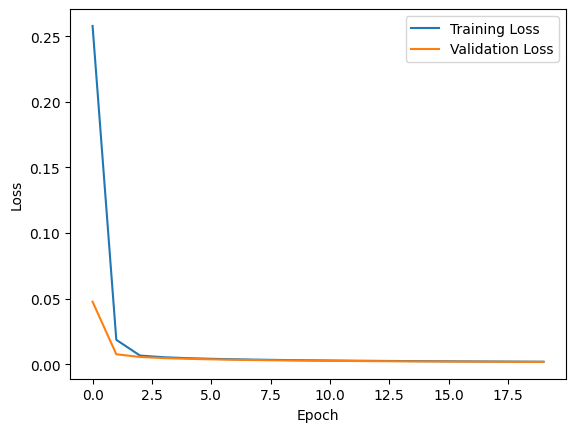

In [ ]:
### START CODE HERE ###
# Change the structure and parameters to train your own model (Can add RNN layer here)
# Reshape X_train and X_val to fit the RNN layer input shape.
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
y_val = y_val.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)

# Construct the model & Set the parameters.
input_size = 1  # Number of input features (1 for single sine wave value)
rnn_units = 64  # Number of units in the RNN layer
dense_units = 64  # Number of units in the Dense layer
output_size = 1  # Number of output classes (1 for single sine wave value)

model = Model()
model.add(RNN(input_size, rnn_units))
model.add(Dense(rnn_units, dense_units))
model.add(Activation("relu", None))
model.add(Dense(dense_units, output_size))
model.add(Activation("linear", None))

# Train the model
model.train(X_train, y_train, X_val, y_val, epochs=20, learning_rate=0.02, batch_size = 16, loss_function='mse')
### END CODE HERE ###

# Plot the training and validation losses
model.plot_losses()

#### Predict testing data & Save the answer (For RNN model)
Remember to submit your prediction to Kaggle!

In [ ]:
### START CODE HERE ###
# Read the X_test.csv file into a DataFrame
# Change the path if needed
X_test_df = pd.read_csv('X_test.csv')
### END CODE HERE ###


# Do not modify this part to get the correct output format!!
# Drop the 'Id' column if it exists
if 'Id' in X_test_df.columns:
    X_test_df = X_test_df.drop(columns=['Id'])

# Convert the DataFrame to a numpy array
X_test = X_test_df.values
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))  # reshape the X_test to fit RNN layer input shape.
y_pred = model.predict(X_test)


# Convert the list of predictions to a numpy array
y_pred = np.array(y_pred)
y_pred_df = pd.DataFrame(y_pred, columns=['answer'])
y_pred_df.insert(0, 'Id', range(1, 1 + len(y_pred_df)))
y_pred_df.to_csv('y_pred_basic.csv', index=False)

print('Prediction data has been saved.')

FileNotFoundError: [Errno 2] No such file or directory: 'X_test.csv'

# Advance part (35%)






## Accelerometer and Gyroscope dataset
- ⚠⚠ You need to download the training & testing data from Kaggle. ⚠⚠ (Put it into the directory name `Activity data`, or your need to change the path in template.)
- In this dataset, we provide the time-series Accelerometer and Gyroscope data each with 3-axial (x, y, z) (total 6 channels).
- We classified the activity into 3 different classes:
    Activity 1, 2, 3\
    You have to build a RNN model using these time-series data to predict the activity class.
- Steps:
    1. Load the provided `X_train.npy`, `y_train.npy` and `X_test.npy` and split the part of training data to validation.\
    Note: `y_train.npy` is already one-hot encoded.
    2. Visualize the `X_train.npy`.
    3. One-hot encode the `y_train.npy` for three classes: Activity 1, Activity 2, Activity 3.
    4. Build your own RNN model and train it.
    5. Predict with the `X_test.npy` and generate `y_test.csv` then **submit it to Kaggle**!
- We have set 3 baselines on public score:
    * Accuracy >= 0.65 -> 10 points
    * Accuracy >= 0.7  -> 20 points
    * Accuracy >= 0.75 -> 25 points
- Kaggle link: https://www.kaggle.com/t/95e0b11f63e74566802b0dea5ec4f1b4


### 1. Load training & testing data
Load the training and testing data, then split the training data into a validation set using your preferred ratio.

In [ ]:
### START CODE HERE ###
# Load X_train, y_train and X_test data
# Change the path if needed
y_train = np.load('y_train.npy')
X_train = np.load('X_train.npy')
X_test = np.load('X_test.npy')

X_mean = np.mean(X_train, axis=0)
X_std = np.std(X_train, axis=0)
X_train = (X_train - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
### END CODE HERE ###

### START CODE HERE ###
# Define the validation ratio in your preferred way
# 1. One-hot encode y_train. (3 classes)
# 2. Split the X_train, y_train data into train & validation set.
validation_ratio = 0.15
num_classes = 3
split_index = int(X_train.shape[0] * (1 - validation_ratio))
X_train, X_val = X_train[:split_index], X_train[split_index:]
y_train, y_val = y_train[:split_index], y_train[split_index:]
y_train_onehot = np.zeros((y_train.shape[0], num_classes))
y_val_onehot = np.zeros((y_val.shape[0], num_classes))
for i, label in enumerate(y_train):
    y_train_onehot[i, label] = 1
for i, label in enumerate(y_val):
    y_val_onehot[i, label] = 1
### END CODE HERE ###



X_train shape: (7352, 128, 6)
y_train shape: (7352, 1)
X_test shape: (2947, 128, 6)


### 2. Visualize the training data

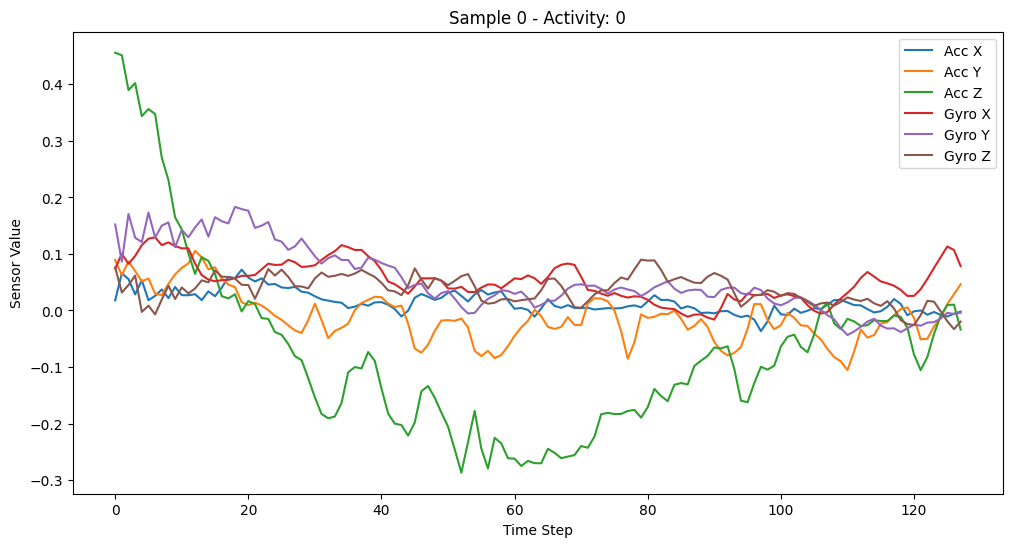

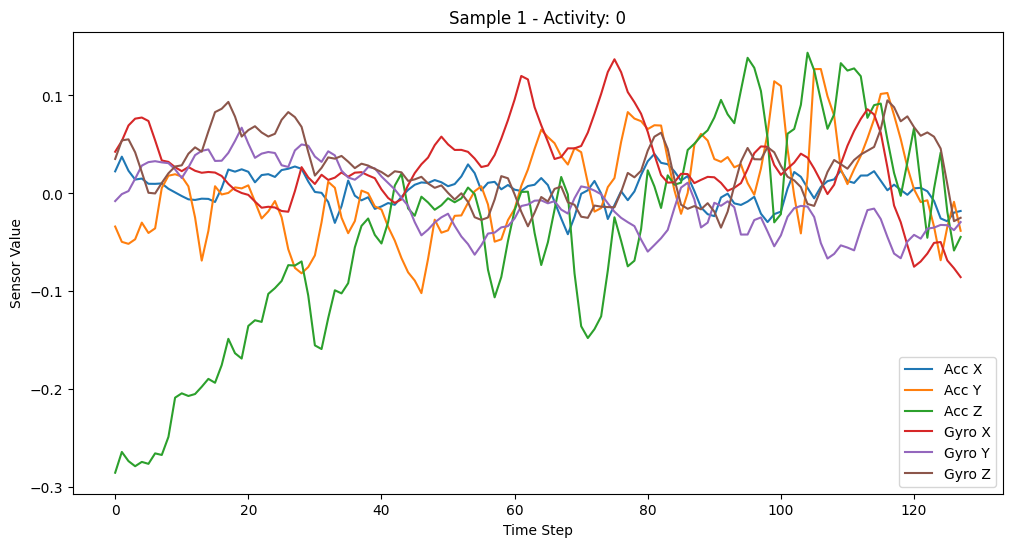

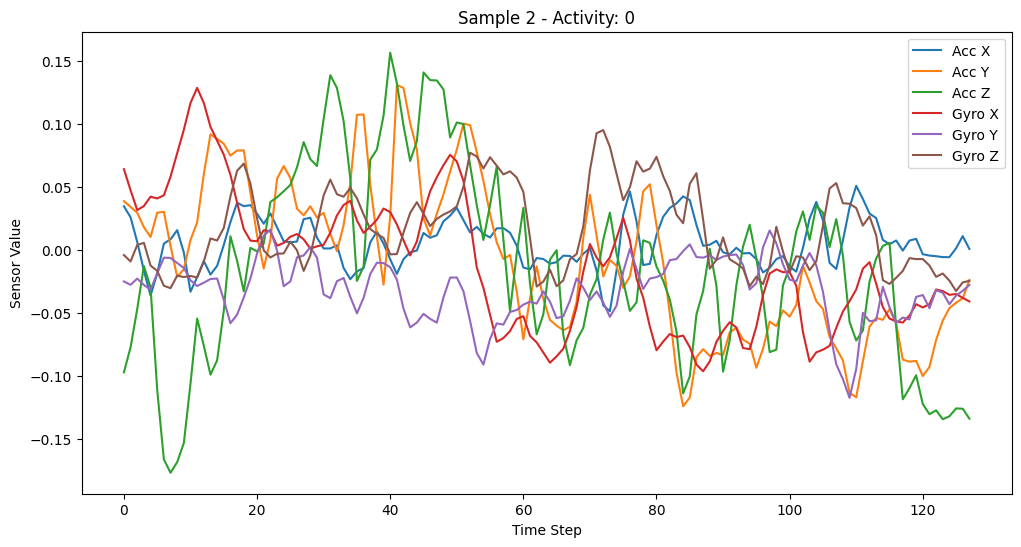

In [ ]:
# Function to plot a single sample
def plot_sample(X, y, sample_index):
    plt.figure(figsize=(12, 6))
    plt.plot(X[sample_index, :, 0], label='Acc X')
    plt.plot(X[sample_index, :, 1], label='Acc Y')
    plt.plot(X[sample_index, :, 2], label='Acc Z')
    plt.plot(X[sample_index, :, 3], label='Gyro X')
    plt.plot(X[sample_index, :, 4], label='Gyro Y')
    plt.plot(X[sample_index, :, 5], label='Gyro Z')
    plt.title(f'Sample {sample_index} - Activity: {np.argmax(y[sample_index])}')
    plt.xlabel('Time Step')
    plt.ylabel('Sensor Value')
    plt.legend()
    plt.show()

### START CODE HERE ###
# Plot a few samples
for i in range(3):              # Change the range to visualize more samples
    plot_sample(X_train, y_train, i)
 ### END CODE HERE ###

### 3. Construct and train the model

Epoch 1/165: 100%|██████████| 196/196 [02:06<00:00,  1.55batch/s, loss=1.07]


Epoch 1/165, Training Loss: 1.0722661305372707
Epoch 1/165, Validation Loss: 1.0355799409785482


Epoch 2/165: 100%|██████████| 196/196 [02:02<00:00,  1.60batch/s, loss=1.01]


Epoch 2/165, Training Loss: 1.018008094002651
Epoch 2/165, Validation Loss: 0.9900444450999111


Epoch 3/165: 100%|██████████| 196/196 [02:02<00:00,  1.60batch/s, loss=0.975]


Epoch 3/165, Training Loss: 0.9800511353945013
Epoch 3/165, Validation Loss: 0.9576687566736466


Epoch 4/165: 100%|██████████| 196/196 [02:02<00:00,  1.60batch/s, loss=0.947]


Epoch 4/165, Training Loss: 0.952004413708562
Epoch 4/165, Validation Loss: 0.9327528759933208


Epoch 5/165: 100%|██████████| 196/196 [02:01<00:00,  1.61batch/s, loss=0.925]


Epoch 5/165, Training Loss: 0.9294636725773089
Epoch 5/165, Validation Loss: 0.9120968065226058


Epoch 6/165: 100%|██████████| 196/196 [02:02<00:00,  1.60batch/s, loss=0.905]


Epoch 6/165, Training Loss: 0.9099289692750594
Epoch 6/165, Validation Loss: 0.8937248070471744


Epoch 7/165: 100%|██████████| 196/196 [02:01<00:00,  1.61batch/s, loss=0.887]


Epoch 7/165, Training Loss: 0.8919295494102187
Epoch 7/165, Validation Loss: 0.8764857230902091


Epoch 8/165: 100%|██████████| 196/196 [02:01<00:00,  1.61batch/s, loss=0.87]


Epoch 8/165, Training Loss: 0.8745609686330161
Epoch 8/165, Validation Loss: 0.8596558814440399


Epoch 9/165: 100%|██████████| 196/196 [02:03<00:00,  1.58batch/s, loss=0.853]


Epoch 9/165, Training Loss: 0.8572803992929182
Epoch 9/165, Validation Loss: 0.842799306154732


Epoch 10/165: 100%|██████████| 196/196 [02:02<00:00,  1.60batch/s, loss=0.836]


Epoch 10/165, Training Loss: 0.8397898403234463
Epoch 10/165, Validation Loss: 0.8256453643063766


Epoch 11/165: 100%|██████████| 196/196 [02:02<00:00,  1.60batch/s, loss=0.818]


Epoch 11/165, Training Loss: 0.8219392608223106
Epoch 11/165, Validation Loss: 0.8080662048640527


Epoch 12/165: 100%|██████████| 196/196 [02:01<00:00,  1.61batch/s, loss=0.8]


Epoch 12/165, Training Loss: 0.8036729746949092
Epoch 12/165, Validation Loss: 0.7900365908592887


Epoch 13/165: 100%|██████████| 196/196 [02:02<00:00,  1.60batch/s, loss=0.781]


Epoch 13/165, Training Loss: 0.7850027566184963
Epoch 13/165, Validation Loss: 0.7715483951022598


Epoch 14/165: 100%|██████████| 196/196 [02:01<00:00,  1.62batch/s, loss=0.762]


Epoch 14/165, Training Loss: 0.7660201342259654
Epoch 14/165, Validation Loss: 0.7527298921758405


Epoch 15/165: 100%|██████████| 196/196 [02:02<00:00,  1.61batch/s, loss=0.743]


Epoch 15/165, Training Loss: 0.7468684361711311
Epoch 15/165, Validation Loss: 0.7336675066385899


Epoch 16/165: 100%|██████████| 196/196 [02:02<00:00,  1.60batch/s, loss=0.724]


Epoch 16/165, Training Loss: 0.7276763391389033
Epoch 16/165, Validation Loss: 0.7144794619502755


Epoch 17/165: 100%|██████████| 196/196 [02:01<00:00,  1.61batch/s, loss=0.705]


Epoch 17/165, Training Loss: 0.7085622036566187
Epoch 17/165, Validation Loss: 0.6953135831501837


Epoch 18/165: 100%|██████████| 196/196 [02:02<00:00,  1.60batch/s, loss=0.686]


Epoch 18/165, Training Loss: 0.689629885036222
Epoch 18/165, Validation Loss: 0.6762429178934363


Epoch 19/165: 100%|██████████| 196/196 [02:02<00:00,  1.60batch/s, loss=0.668]


Epoch 19/165, Training Loss: 0.6709560103885018
Epoch 19/165, Validation Loss: 0.6573430235677435


Epoch 20/165: 100%|██████████| 196/196 [02:04<00:00,  1.58batch/s, loss=0.649]


Epoch 20/165, Training Loss: 0.6526138389667272
Epoch 20/165, Validation Loss: 0.6386831670174623


Epoch 21/165: 100%|██████████| 196/196 [02:03<00:00,  1.59batch/s, loss=0.631]


Epoch 21/165, Training Loss: 0.6346530066215366
Epoch 21/165, Validation Loss: 0.6203195669124185


Epoch 22/165: 100%|██████████| 196/196 [02:01<00:00,  1.61batch/s, loss=0.614]


Epoch 22/165, Training Loss: 0.6171414151489434
Epoch 22/165, Validation Loss: 0.6022850932761884


Epoch 23/165: 100%|██████████| 196/196 [02:03<00:00,  1.59batch/s, loss=0.597]


Epoch 23/165, Training Loss: 0.600139082445669
Epoch 23/165, Validation Loss: 0.5846150873697935


Epoch 24/165: 100%|██████████| 196/196 [02:02<00:00,  1.60batch/s, loss=0.581]


Epoch 24/165, Training Loss: 0.5836601581812056
Epoch 24/165, Validation Loss: 0.5673369124650738


Epoch 25/165: 100%|██████████| 196/196 [02:03<00:00,  1.59batch/s, loss=0.565]


Epoch 25/165, Training Loss: 0.5677543019390634
Epoch 25/165, Validation Loss: 0.550487981917127


Epoch 26/165: 100%|██████████| 196/196 [02:03<00:00,  1.58batch/s, loss=0.549]


Epoch 26/165, Training Loss: 0.5524423411515029
Epoch 26/165, Validation Loss: 0.5340730086258975


Epoch 27/165: 100%|██████████| 196/196 [02:02<00:00,  1.61batch/s, loss=0.535]


Epoch 27/165, Training Loss: 0.5377569210293985
Epoch 27/165, Validation Loss: 0.5180911353458657


Epoch 28/165: 100%|██████████| 196/196 [02:02<00:00,  1.59batch/s, loss=0.521]


Epoch 28/165, Training Loss: 0.5237792853450715
Epoch 28/165, Validation Loss: 0.5027972421616502


Epoch 29/165: 100%|██████████| 196/196 [02:02<00:00,  1.60batch/s, loss=0.508]


Epoch 29/165, Training Loss: 0.5106481318742139
Epoch 29/165, Validation Loss: 0.48836470534515597


Epoch 30/165: 100%|██████████| 196/196 [02:01<00:00,  1.61batch/s, loss=0.496]


Epoch 30/165, Training Loss: 0.49859758990768727
Epoch 30/165, Validation Loss: 0.47506764319295514


Epoch 31/165: 100%|██████████| 196/196 [02:02<00:00,  1.60batch/s, loss=0.485]


Epoch 31/165, Training Loss: 0.48783310198856594
Epoch 31/165, Validation Loss: 0.4630252154588086


Epoch 32/165: 100%|██████████| 196/196 [02:04<00:00,  1.58batch/s, loss=0.476]


Epoch 32/165, Training Loss: 0.47835012935779603
Epoch 32/165, Validation Loss: 0.4522377811890609


Epoch 33/165: 100%|██████████| 196/196 [02:02<00:00,  1.60batch/s, loss=0.467]


Epoch 33/165, Training Loss: 0.47011983938987095
Epoch 33/165, Validation Loss: 0.4426999744707314


Epoch 34/165: 100%|██████████| 196/196 [02:03<00:00,  1.58batch/s, loss=0.46]


Epoch 34/165, Training Loss: 0.46298750006483647
Epoch 34/165, Validation Loss: 0.4343842000953752


Epoch 35/165: 100%|██████████| 196/196 [02:03<00:00,  1.59batch/s, loss=0.454]


Epoch 35/165, Training Loss: 0.4567116192146559
Epoch 35/165, Validation Loss: 0.42706010607182937


Epoch 36/165: 100%|██████████| 196/196 [02:02<00:00,  1.60batch/s, loss=0.448]


Epoch 36/165, Training Loss: 0.451095242923716
Epoch 36/165, Validation Loss: 0.42063771810071293


Epoch 37/165: 100%|██████████| 196/196 [02:01<00:00,  1.61batch/s, loss=0.443]


Epoch 37/165, Training Loss: 0.44596329390515044
Epoch 37/165, Validation Loss: 0.414926850010481


Epoch 38/165: 100%|██████████| 196/196 [02:01<00:00,  1.61batch/s, loss=0.438]


Epoch 38/165, Training Loss: 0.44120105864582126
Epoch 38/165, Validation Loss: 0.40975697607102696


Epoch 39/165: 100%|██████████| 196/196 [02:01<00:00,  1.61batch/s, loss=0.434]


Epoch 39/165, Training Loss: 0.4367126056038214
Epoch 39/165, Validation Loss: 0.405029460326857


Epoch 40/165: 100%|██████████| 196/196 [02:01<00:00,  1.62batch/s, loss=0.43]


Epoch 40/165, Training Loss: 0.4324853476854625
Epoch 40/165, Validation Loss: 0.4006282835624919


Epoch 41/165: 100%|██████████| 196/196 [02:01<00:00,  1.62batch/s, loss=0.426]


Epoch 41/165, Training Loss: 0.42848332015791074
Epoch 41/165, Validation Loss: 0.39651024909450533


Epoch 42/165: 100%|██████████| 196/196 [02:01<00:00,  1.61batch/s, loss=0.422]


Epoch 42/165, Training Loss: 0.4246405882881232
Epoch 42/165, Validation Loss: 0.3926545132524112


Epoch 43/165: 100%|██████████| 196/196 [02:02<00:00,  1.59batch/s, loss=0.418]


Epoch 43/165, Training Loss: 0.4209915238812784
Epoch 43/165, Validation Loss: 0.38899529354135265


Epoch 44/165: 100%|██████████| 196/196 [02:04<00:00,  1.57batch/s, loss=0.415]


Epoch 44/165, Training Loss: 0.4174746744435151
Epoch 44/165, Validation Loss: 0.38551292782776136


Epoch 45/165: 100%|██████████| 196/196 [02:05<00:00,  1.57batch/s, loss=0.411]


Epoch 45/165, Training Loss: 0.41409207059323855
Epoch 45/165, Validation Loss: 0.38219150572751215


Epoch 46/165: 100%|██████████| 196/196 [02:04<00:00,  1.57batch/s, loss=0.408]


Epoch 46/165, Training Loss: 0.41082766673150595
Epoch 46/165, Validation Loss: 0.3790121567138003


Epoch 47/165: 100%|██████████| 196/196 [02:04<00:00,  1.57batch/s, loss=0.405]


Epoch 47/165, Training Loss: 0.4076685181621433
Epoch 47/165, Validation Loss: 0.37596792804214696


Epoch 48/165: 100%|██████████| 196/196 [02:07<00:00,  1.53batch/s, loss=0.402]


Epoch 48/165, Training Loss: 0.4046156746539298
Epoch 48/165, Validation Loss: 0.37304515120029963


Epoch 49/165: 100%|██████████| 196/196 [02:04<00:00,  1.58batch/s, loss=0.399]


Epoch 49/165, Training Loss: 0.40162313602492333
Epoch 49/165, Validation Loss: 0.3702411973229767


Epoch 50/165: 100%|██████████| 196/196 [02:04<00:00,  1.57batch/s, loss=0.396]


Epoch 50/165, Training Loss: 0.3987390214261839
Epoch 50/165, Validation Loss: 0.3675432489006352


Epoch 51/165: 100%|██████████| 196/196 [02:03<00:00,  1.59batch/s, loss=0.393]


Epoch 51/165, Training Loss: 0.39593249878945996
Epoch 51/165, Validation Loss: 0.3649193353376527


Epoch 52/165: 100%|██████████| 196/196 [02:03<00:00,  1.58batch/s, loss=0.39]


Epoch 52/165, Training Loss: 0.3932191782872763
Epoch 52/165, Validation Loss: 0.36240861273105357


Epoch 53/165: 100%|██████████| 196/196 [02:05<00:00,  1.56batch/s, loss=0.388]


Epoch 53/165, Training Loss: 0.3905353437247595
Epoch 53/165, Validation Loss: 0.3600074930084226


Epoch 54/165: 100%|██████████| 196/196 [02:03<00:00,  1.58batch/s, loss=0.385]


Epoch 54/165, Training Loss: 0.38794038055418484
Epoch 54/165, Validation Loss: 0.35763018714809763


Epoch 55/165: 100%|██████████| 196/196 [02:03<00:00,  1.59batch/s, loss=0.383]


Epoch 55/165, Training Loss: 0.3853618176361899
Epoch 55/165, Validation Loss: 0.3553600857505982


Epoch 56/165: 100%|██████████| 196/196 [02:08<00:00,  1.52batch/s, loss=0.38]


Epoch 56/165, Training Loss: 0.38285880680678036
Epoch 56/165, Validation Loss: 0.35321140850149785


Epoch 57/165: 100%|██████████| 196/196 [02:03<00:00,  1.58batch/s, loss=0.377]


Epoch 57/165, Training Loss: 0.38040740972901294
Epoch 57/165, Validation Loss: 0.35115867286920527


Epoch 58/165: 100%|██████████| 196/196 [02:03<00:00,  1.59batch/s, loss=0.375]


Epoch 58/165, Training Loss: 0.3780248805020731
Epoch 58/165, Validation Loss: 0.34915438715930525


Epoch 59/165: 100%|██████████| 196/196 [02:02<00:00,  1.60batch/s, loss=0.373]


Epoch 59/165, Training Loss: 0.3757031863855393
Epoch 59/165, Validation Loss: 0.34721138884520536


Epoch 60/165: 100%|██████████| 196/196 [02:03<00:00,  1.59batch/s, loss=0.37]


Epoch 60/165, Training Loss: 0.37340829804403747
Epoch 60/165, Validation Loss: 0.34534496164072204


Epoch 61/165: 100%|██████████| 196/196 [02:04<00:00,  1.58batch/s, loss=0.368]


Epoch 61/165, Training Loss: 0.3711741320241996
Epoch 61/165, Validation Loss: 0.34352364180111283


Epoch 62/165: 100%|██████████| 196/196 [02:05<00:00,  1.56batch/s, loss=0.366]


Epoch 62/165, Training Loss: 0.3689453278119719
Epoch 62/165, Validation Loss: 0.3417862713517433


Epoch 63/165: 100%|██████████| 196/196 [02:06<00:00,  1.55batch/s, loss=0.364]


Epoch 63/165, Training Loss: 0.36680281496666367
Epoch 63/165, Validation Loss: 0.34012059812995005


Epoch 64/165: 100%|██████████| 196/196 [02:06<00:00,  1.55batch/s, loss=0.362]


Epoch 64/165, Training Loss: 0.3647077021268231
Epoch 64/165, Validation Loss: 0.33848851788209633


Epoch 65/165: 100%|██████████| 196/196 [02:03<00:00,  1.59batch/s, loss=0.359]


Epoch 65/165, Training Loss: 0.3626827482393161
Epoch 65/165, Validation Loss: 0.336873738115044


Epoch 66/165: 100%|██████████| 196/196 [02:03<00:00,  1.59batch/s, loss=0.357]


Epoch 66/165, Training Loss: 0.36070548268751784
Epoch 66/165, Validation Loss: 0.3352823650945057


Epoch 67/165: 100%|██████████| 196/196 [02:03<00:00,  1.59batch/s, loss=0.356]


Epoch 67/165, Training Loss: 0.35878787707813586
Epoch 67/165, Validation Loss: 0.3337207666732046


Epoch 68/165: 100%|██████████| 196/196 [02:02<00:00,  1.60batch/s, loss=0.354]


Epoch 68/165, Training Loss: 0.3568914815762451
Epoch 68/165, Validation Loss: 0.33215868020793565


Epoch 69/165: 100%|██████████| 196/196 [02:04<00:00,  1.58batch/s, loss=0.352]


Epoch 69/165, Training Loss: 0.35502173167860906
Epoch 69/165, Validation Loss: 0.3306155659677658


Epoch 70/165: 100%|██████████| 196/196 [02:09<00:00,  1.51batch/s, loss=0.35]


Epoch 70/165, Training Loss: 0.353188175317431
Epoch 70/165, Validation Loss: 0.3290849407575342


Epoch 71/165: 100%|██████████| 196/196 [02:06<00:00,  1.55batch/s, loss=0.348]


Epoch 71/165, Training Loss: 0.351345244603641
Epoch 71/165, Validation Loss: 0.32757795218730984


Epoch 72/165: 100%|██████████| 196/196 [02:04<00:00,  1.58batch/s, loss=0.346]


Epoch 72/165, Training Loss: 0.3495225726322785
Epoch 72/165, Validation Loss: 0.3260734459723897


Epoch 73/165: 100%|██████████| 196/196 [02:03<00:00,  1.59batch/s, loss=0.344]


Epoch 73/165, Training Loss: 0.34770101636197664
Epoch 73/165, Validation Loss: 0.32457270615767686


Epoch 74/165: 100%|██████████| 196/196 [02:05<00:00,  1.57batch/s, loss=0.343]


Epoch 74/165, Training Loss: 0.3459150945691526
Epoch 74/165, Validation Loss: 0.323052313118846


Epoch 75/165: 100%|██████████| 196/196 [02:03<00:00,  1.59batch/s, loss=0.341]


Epoch 75/165, Training Loss: 0.34413426356261323
Epoch 75/165, Validation Loss: 0.32150265582043985


Epoch 76/165: 100%|██████████| 196/196 [02:04<00:00,  1.58batch/s, loss=0.339]


Epoch 76/165, Training Loss: 0.342297958171094
Epoch 76/165, Validation Loss: 0.31996375778359953


Epoch 77/165: 100%|██████████| 196/196 [02:03<00:00,  1.59batch/s, loss=0.337]


Epoch 77/165, Training Loss: 0.3404545416706905
Epoch 77/165, Validation Loss: 0.318420038849129


Epoch 78/165: 100%|██████████| 196/196 [02:03<00:00,  1.59batch/s, loss=0.335]


Epoch 78/165, Training Loss: 0.33862759917460566
Epoch 78/165, Validation Loss: 0.3168597799012704


Epoch 79/165: 100%|██████████| 196/196 [02:03<00:00,  1.58batch/s, loss=0.333]


Epoch 79/165, Training Loss: 0.336771991437013
Epoch 79/165, Validation Loss: 0.31530967047906955


Epoch 80/165: 100%|██████████| 196/196 [02:02<00:00,  1.60batch/s, loss=0.331]


Epoch 80/165, Training Loss: 0.3348963435146964
Epoch 80/165, Validation Loss: 0.3137553770256838


Epoch 81/165: 100%|██████████| 196/196 [02:02<00:00,  1.60batch/s, loss=0.33]


Epoch 81/165, Training Loss: 0.3329851104114281
Epoch 81/165, Validation Loss: 0.3122342690607767


Epoch 82/165: 100%|██████████| 196/196 [02:06<00:00,  1.55batch/s, loss=0.328]


Epoch 82/165, Training Loss: 0.3310530621102625
Epoch 82/165, Validation Loss: 0.31064868240915916


Epoch 83/165: 100%|██████████| 196/196 [02:03<00:00,  1.59batch/s, loss=0.326]


Epoch 83/165, Training Loss: 0.3290775482701428
Epoch 83/165, Validation Loss: 0.3090112509153538


Epoch 84/165: 100%|██████████| 196/196 [02:01<00:00,  1.61batch/s, loss=0.324]


Epoch 84/165, Training Loss: 0.32707268077636564
Epoch 84/165, Validation Loss: 0.3073196368411741


Epoch 85/165: 100%|██████████| 196/196 [02:03<00:00,  1.59batch/s, loss=0.322]


Epoch 85/165, Training Loss: 0.32501809922215114
Epoch 85/165, Validation Loss: 0.30560854510841445


Epoch 86/165: 100%|██████████| 196/196 [02:02<00:00,  1.61batch/s, loss=0.319]


Epoch 86/165, Training Loss: 0.3229176668125216
Epoch 86/165, Validation Loss: 0.30384761578251096


Epoch 87/165: 100%|██████████| 196/196 [02:03<00:00,  1.58batch/s, loss=0.317]


Epoch 87/165, Training Loss: 0.3207657956087107
Epoch 87/165, Validation Loss: 0.3020258013769027


Epoch 88/165: 100%|██████████| 196/196 [02:01<00:00,  1.61batch/s, loss=0.315]


Epoch 88/165, Training Loss: 0.31854336257291344
Epoch 88/165, Validation Loss: 0.3001338226695428


Epoch 89/165: 100%|██████████| 196/196 [02:02<00:00,  1.60batch/s, loss=0.313]


Epoch 89/165, Training Loss: 0.316257166951513
Epoch 89/165, Validation Loss: 0.2982333568794567


Epoch 90/165: 100%|██████████| 196/196 [02:01<00:00,  1.62batch/s, loss=0.31]


Epoch 90/165, Training Loss: 0.31388845431551454
Epoch 90/165, Validation Loss: 0.29628101603840973


Epoch 91/165: 100%|██████████| 196/196 [02:00<00:00,  1.63batch/s, loss=0.308]


Epoch 91/165, Training Loss: 0.3114409767553521
Epoch 91/165, Validation Loss: 0.29432652649802066


Epoch 92/165: 100%|██████████| 196/196 [02:00<00:00,  1.62batch/s, loss=0.306]


Epoch 92/165, Training Loss: 0.3089615551132502
Epoch 92/165, Validation Loss: 0.29227809037507163


Epoch 93/165: 100%|██████████| 196/196 [02:01<00:00,  1.62batch/s, loss=0.303]


Epoch 93/165, Training Loss: 0.3063744445195458
Epoch 93/165, Validation Loss: 0.2901879296293587


Epoch 94/165: 100%|██████████| 196/196 [02:03<00:00,  1.59batch/s, loss=0.3]


Epoch 94/165, Training Loss: 0.30373674990517197
Epoch 94/165, Validation Loss: 0.2880604538861113


Epoch 95/165: 100%|██████████| 196/196 [02:01<00:00,  1.61batch/s, loss=0.298]


Epoch 95/165, Training Loss: 0.3010067416157254
Epoch 95/165, Validation Loss: 0.2858634440461444


Epoch 96/165: 100%|██████████| 196/196 [02:01<00:00,  1.61batch/s, loss=0.295]


Epoch 96/165, Training Loss: 0.2982165569778429
Epoch 96/165, Validation Loss: 0.2836011269870221


Epoch 97/165: 100%|██████████| 196/196 [02:52<00:00,  1.13batch/s, loss=0.292]


Epoch 97/165, Training Loss: 0.2953788961223615
Epoch 97/165, Validation Loss: 0.28129566195857275


Epoch 98/165: 100%|██████████| 196/196 [02:01<00:00,  1.61batch/s, loss=0.289]


Epoch 98/165, Training Loss: 0.2925094518539968
Epoch 98/165, Validation Loss: 0.27895072306765034


Epoch 99/165: 100%|██████████| 196/196 [02:00<00:00,  1.62batch/s, loss=0.286]


Epoch 99/165, Training Loss: 0.28955740369465094
Epoch 99/165, Validation Loss: 0.2765171905147506


Epoch 100/165: 100%|██████████| 196/196 [02:02<00:00,  1.60batch/s, loss=0.284]


Epoch 100/165, Training Loss: 0.28662201060079573
Epoch 100/165, Validation Loss: 0.27410457408797206


Epoch 101/165: 100%|██████████| 196/196 [02:01<00:00,  1.61batch/s, loss=0.281]


Epoch 101/165, Training Loss: 0.28370219517640516
Epoch 101/165, Validation Loss: 0.2715486626057681


Epoch 102/165: 100%|██████████| 196/196 [02:00<00:00,  1.63batch/s, loss=0.278]


Epoch 102/165, Training Loss: 0.28075985188112323
Epoch 102/165, Validation Loss: 0.2690879026793175


Epoch 103/165: 100%|██████████| 196/196 [01:59<00:00,  1.64batch/s, loss=0.275]


Epoch 103/165, Training Loss: 0.27784945739145267
Epoch 103/165, Validation Loss: 0.2666828966477721


Epoch 104/165: 100%|██████████| 196/196 [02:01<00:00,  1.61batch/s, loss=0.272]


Epoch 104/165, Training Loss: 0.2750800324266257
Epoch 104/165, Validation Loss: 0.2642931724201213


Epoch 105/165: 100%|██████████| 196/196 [02:01<00:00,  1.62batch/s, loss=0.27]


Epoch 105/165, Training Loss: 0.27235608726590493
Epoch 105/165, Validation Loss: 0.26181256429505123


Epoch 106/165: 100%|██████████| 196/196 [02:02<00:00,  1.60batch/s, loss=0.267]


Epoch 106/165, Training Loss: 0.2696597412038136
Epoch 106/165, Validation Loss: 0.2593663307581633


Epoch 107/165: 100%|██████████| 196/196 [02:00<00:00,  1.62batch/s, loss=0.264]


Epoch 107/165, Training Loss: 0.26702164544871837
Epoch 107/165, Validation Loss: 0.2569147970955403


Epoch 108/165: 100%|██████████| 196/196 [02:02<00:00,  1.60batch/s, loss=0.262]


Epoch 108/165, Training Loss: 0.26448257417385496
Epoch 108/165, Validation Loss: 0.2545348137369837


Epoch 109/165: 100%|██████████| 196/196 [02:01<00:00,  1.61batch/s, loss=0.259]


Epoch 109/165, Training Loss: 0.26197742911656585
Epoch 109/165, Validation Loss: 0.25219047545416495


Epoch 110/165: 100%|██████████| 196/196 [02:01<00:00,  1.62batch/s, loss=0.257]


Epoch 110/165, Training Loss: 0.2594564010194411
Epoch 110/165, Validation Loss: 0.24986677233657384


Epoch 111/165: 100%|██████████| 196/196 [01:59<00:00,  1.63batch/s, loss=0.255]


Epoch 111/165, Training Loss: 0.25708441567407836
Epoch 111/165, Validation Loss: 0.24758763710240472


Epoch 112/165: 100%|██████████| 196/196 [02:01<00:00,  1.62batch/s, loss=0.252]


Epoch 112/165, Training Loss: 0.2546896573557125
Epoch 112/165, Validation Loss: 0.24529444460196947


Epoch 113/165: 100%|██████████| 196/196 [02:00<00:00,  1.62batch/s, loss=0.25]


Epoch 113/165, Training Loss: 0.2523994766666905
Epoch 113/165, Validation Loss: 0.2430898411710842


Epoch 114/165: 100%|██████████| 196/196 [02:01<00:00,  1.62batch/s, loss=0.248]


Epoch 114/165, Training Loss: 0.25007939019691483
Epoch 114/165, Validation Loss: 0.2408616286666402


Epoch 115/165: 100%|██████████| 196/196 [02:01<00:00,  1.61batch/s, loss=0.246]


Epoch 115/165, Training Loss: 0.24780468588488647
Epoch 115/165, Validation Loss: 0.238570406347342


Epoch 116/165: 100%|██████████| 196/196 [02:01<00:00,  1.61batch/s, loss=0.243]


Epoch 116/165, Training Loss: 0.2454334570417411
Epoch 116/165, Validation Loss: 0.23624845374874648


Epoch 117/165: 100%|██████████| 196/196 [02:02<00:00,  1.61batch/s, loss=0.241]


Epoch 117/165, Training Loss: 0.2431396290248917
Epoch 117/165, Validation Loss: 0.23391323384860724


Epoch 118/165: 100%|██████████| 196/196 [02:00<00:00,  1.62batch/s, loss=0.239]


Epoch 118/165, Training Loss: 0.24083656700296302
Epoch 118/165, Validation Loss: 0.2315029591681737


Epoch 119/165: 100%|██████████| 196/196 [02:02<00:00,  1.60batch/s, loss=0.237]


Epoch 119/165, Training Loss: 0.23854605024874187
Epoch 119/165, Validation Loss: 0.229047294972309


Epoch 120/165: 100%|██████████| 196/196 [02:01<00:00,  1.61batch/s, loss=0.234]


Epoch 120/165, Training Loss: 0.23617907392477802
Epoch 120/165, Validation Loss: 0.22647560014299767


Epoch 121/165: 100%|██████████| 196/196 [02:02<00:00,  1.61batch/s, loss=0.232]


Epoch 121/165, Training Loss: 0.2337051360782748
Epoch 121/165, Validation Loss: 0.2237768158688834


Epoch 122/165: 100%|██████████| 196/196 [02:01<00:00,  1.61batch/s, loss=0.229]


Epoch 122/165, Training Loss: 0.23118047034623074
Epoch 122/165, Validation Loss: 0.22101335972966982


Epoch 123/165: 100%|██████████| 196/196 [02:01<00:00,  1.61batch/s, loss=0.227]


Epoch 123/165, Training Loss: 0.22848645438897652
Epoch 123/165, Validation Loss: 0.21817724081607154


Epoch 124/165: 100%|██████████| 196/196 [02:01<00:00,  1.61batch/s, loss=0.224]


Epoch 124/165, Training Loss: 0.22575915286848483
Epoch 124/165, Validation Loss: 0.21514387298611817


Epoch 125/165: 100%|██████████| 196/196 [02:01<00:00,  1.61batch/s, loss=0.221]


Epoch 125/165, Training Loss: 0.22282245107372675
Epoch 125/165, Validation Loss: 0.21196585839586052


Epoch 126/165: 100%|██████████| 196/196 [02:01<00:00,  1.61batch/s, loss=0.218]


Epoch 126/165, Training Loss: 0.21970684413453176
Epoch 126/165, Validation Loss: 0.2086188722332155


Epoch 127/165: 100%|██████████| 196/196 [02:01<00:00,  1.62batch/s, loss=0.215]


Epoch 127/165, Training Loss: 0.21636556696372333
Epoch 127/165, Validation Loss: 0.20506154631260837


Epoch 128/165: 100%|██████████| 196/196 [02:01<00:00,  1.62batch/s, loss=0.212]


Epoch 128/165, Training Loss: 0.21289412981319178
Epoch 128/165, Validation Loss: 0.20129652919042132


Epoch 129/165: 100%|██████████| 196/196 [02:00<00:00,  1.63batch/s, loss=0.208]


Epoch 129/165, Training Loss: 0.20908419625976413
Epoch 129/165, Validation Loss: 0.197442145176681


Epoch 130/165: 100%|██████████| 196/196 [02:01<00:00,  1.62batch/s, loss=0.204]


Epoch 130/165, Training Loss: 0.20506974093718885
Epoch 130/165, Validation Loss: 0.1931694164691933


Epoch 131/165: 100%|██████████| 196/196 [02:00<00:00,  1.62batch/s, loss=0.2]


Epoch 131/165, Training Loss: 0.20088872236172786
Epoch 131/165, Validation Loss: 0.18873823407136514


Epoch 132/165: 100%|██████████| 196/196 [02:01<00:00,  1.61batch/s, loss=0.196]


Epoch 132/165, Training Loss: 0.1964904376636695
Epoch 132/165, Validation Loss: 0.18415992227471803


Epoch 133/165: 100%|██████████| 196/196 [02:01<00:00,  1.62batch/s, loss=0.191]


Epoch 133/165, Training Loss: 0.19194810747423577
Epoch 133/165, Validation Loss: 0.17960699231872174


Epoch 134/165: 100%|██████████| 196/196 [02:49<00:00,  1.16batch/s, loss=0.187]


Epoch 134/165, Training Loss: 0.18732980811223154
Epoch 134/165, Validation Loss: 0.1745864505572058


Epoch 135/165: 100%|██████████| 196/196 [02:00<00:00,  1.63batch/s, loss=0.182]


Epoch 135/165, Training Loss: 0.18221300396383433
Epoch 135/165, Validation Loss: 0.16942488560948643


Epoch 136/165: 100%|██████████| 196/196 [02:02<00:00,  1.60batch/s, loss=0.176]


Epoch 136/165, Training Loss: 0.17703026186651943
Epoch 136/165, Validation Loss: 0.16406554850777974


Epoch 137/165: 100%|██████████| 196/196 [02:02<00:00,  1.60batch/s, loss=0.171]


Epoch 137/165, Training Loss: 0.17195998814043792
Epoch 137/165, Validation Loss: 0.15817724068415798


Epoch 138/165: 100%|██████████| 196/196 [02:02<00:00,  1.60batch/s, loss=0.166]


Epoch 138/165, Training Loss: 0.16686825318898035
Epoch 138/165, Validation Loss: 0.15239745628162232


Epoch 139/165: 100%|██████████| 196/196 [02:02<00:00,  1.60batch/s, loss=0.161]


Epoch 139/165, Training Loss: 0.16182624873581364
Epoch 139/165, Validation Loss: 0.14663245593664667


Epoch 140/165: 100%|██████████| 196/196 [02:01<00:00,  1.61batch/s, loss=0.157]


Epoch 140/165, Training Loss: 0.157005041036755
Epoch 140/165, Validation Loss: 0.14117131477974448


Epoch 141/165: 100%|██████████| 196/196 [02:01<00:00,  1.61batch/s, loss=0.152]


Epoch 141/165, Training Loss: 0.15219759460333582
Epoch 141/165, Validation Loss: 0.13588327952262344


Epoch 142/165: 100%|██████████| 196/196 [02:00<00:00,  1.63batch/s, loss=0.148]


Epoch 142/165, Training Loss: 0.14807834644123236
Epoch 142/165, Validation Loss: 0.1305522873040902


Epoch 143/165: 100%|██████████| 196/196 [02:01<00:00,  1.61batch/s, loss=0.144]


Epoch 143/165, Training Loss: 0.14420754043451706
Epoch 143/165, Validation Loss: 0.12538536766525926


Epoch 144/165: 100%|██████████| 196/196 [02:01<00:00,  1.61batch/s, loss=0.14]


Epoch 144/165, Training Loss: 0.14038987761676078
Epoch 144/165, Validation Loss: 0.12044770166540283


Epoch 145/165: 100%|██████████| 196/196 [02:03<00:00,  1.59batch/s, loss=0.137]


Epoch 145/165, Training Loss: 0.13667660504653237
Epoch 145/165, Validation Loss: 0.11539587205699374


Epoch 146/165: 100%|██████████| 196/196 [02:02<00:00,  1.60batch/s, loss=0.133]


Epoch 146/165, Training Loss: 0.1328931414000945
Epoch 146/165, Validation Loss: 0.11037699964954233


Epoch 147/165: 100%|██████████| 196/196 [02:02<00:00,  1.60batch/s, loss=0.129]


Epoch 147/165, Training Loss: 0.1290620917305477
Epoch 147/165, Validation Loss: 0.10504626956984933


Epoch 148/165: 100%|██████████| 196/196 [02:02<00:00,  1.60batch/s, loss=0.125]


Epoch 148/165, Training Loss: 0.12483198681460254
Epoch 148/165, Validation Loss: 0.10013300496300612


Epoch 149/165: 100%|██████████| 196/196 [02:01<00:00,  1.61batch/s, loss=0.122]


Epoch 149/165, Training Loss: 0.12196117801314975
Epoch 149/165, Validation Loss: 0.09553999512713719


Epoch 150/165: 100%|██████████| 196/196 [02:02<00:00,  1.61batch/s, loss=0.118]


Epoch 150/165, Training Loss: 0.11799393268272892
Epoch 150/165, Validation Loss: 0.09065514162136709


Epoch 151/165: 100%|██████████| 196/196 [02:00<00:00,  1.63batch/s, loss=0.114]


Epoch 151/165, Training Loss: 0.11396297816916492
Epoch 151/165, Validation Loss: 0.08567632727288295


Epoch 152/165: 100%|██████████| 196/196 [02:02<00:00,  1.60batch/s, loss=0.11]


Epoch 152/165, Training Loss: 0.10989741673197186
Epoch 152/165, Validation Loss: 0.08036569528195286


Epoch 153/165: 100%|██████████| 196/196 [02:02<00:00,  1.60batch/s, loss=0.107]


Epoch 153/165, Training Loss: 0.10671206445181086
Epoch 153/165, Validation Loss: 0.07548405228455084


Epoch 154/165: 100%|██████████| 196/196 [02:03<00:00,  1.59batch/s, loss=0.104]


Epoch 154/165, Training Loss: 0.1043483381382347
Epoch 154/165, Validation Loss: 0.07168799483332434


Epoch 155/165: 100%|██████████| 196/196 [02:04<00:00,  1.58batch/s, loss=0.104]


Epoch 155/165, Training Loss: 0.1039755101350115
Epoch 155/165, Validation Loss: 0.06920142590595801


Epoch 156/165: 100%|██████████| 196/196 [02:03<00:00,  1.59batch/s, loss=0.0978]


Epoch 156/165, Training Loss: 0.09762315449941443
Epoch 156/165, Validation Loss: 0.06397266729757883


Epoch 157/165: 100%|██████████| 196/196 [02:01<00:00,  1.61batch/s, loss=0.0974]


Epoch 157/165, Training Loss: 0.09719015804804762
Epoch 157/165, Validation Loss: 0.06125207190447674


Epoch 158/165: 100%|██████████| 196/196 [02:03<00:00,  1.59batch/s, loss=0.0965]


Epoch 158/165, Training Loss: 0.09622762684112439
Epoch 158/165, Validation Loss: 0.059325605117804714


Epoch 159/165: 100%|██████████| 196/196 [02:03<00:00,  1.59batch/s, loss=0.0949]


Epoch 159/165, Training Loss: 0.09464238798066495
Epoch 159/165, Validation Loss: 0.057609348025763674


Epoch 160/165: 100%|██████████| 196/196 [02:05<00:00,  1.56batch/s, loss=0.0903]


Epoch 160/165, Training Loss: 0.09008903771874324
Epoch 160/165, Validation Loss: 0.05505838773283012


Epoch 161/165: 100%|██████████| 196/196 [02:03<00:00,  1.59batch/s, loss=0.0865]


Epoch 161/165, Training Loss: 0.08624555650382106
Epoch 161/165, Validation Loss: 0.05290446222993578


Epoch 162/165: 100%|██████████| 196/196 [02:04<00:00,  1.57batch/s, loss=0.088]


Epoch 162/165, Training Loss: 0.08773266576348247
Epoch 162/165, Validation Loss: 0.050885966230957515


Epoch 163/165: 100%|██████████| 196/196 [02:04<00:00,  1.58batch/s, loss=0.0828]


Epoch 163/165, Training Loss: 0.08254688438420803
Epoch 163/165, Validation Loss: 0.04902581628588441


Epoch 164/165: 100%|██████████| 196/196 [02:04<00:00,  1.58batch/s, loss=0.0816]


Epoch 164/165, Training Loss: 0.08131463116620459
Epoch 164/165, Validation Loss: 0.04754324957325253


Epoch 165/165: 100%|██████████| 196/196 [02:03<00:00,  1.58batch/s, loss=0.0778]


Epoch 165/165, Training Loss: 0.07755486125518254
Epoch 165/165, Validation Loss: 0.04504601116817286


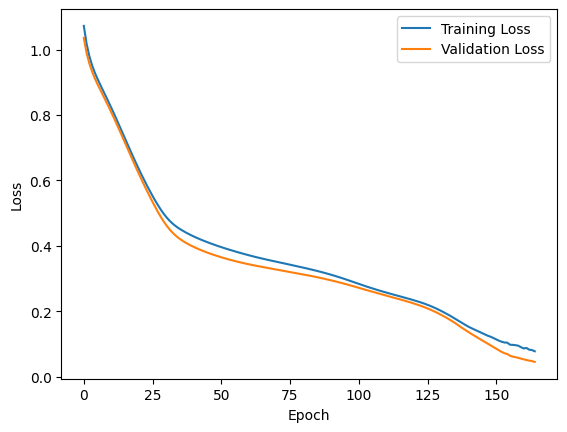

In [ ]:
### START CODE HERE ###
# Construct the model & Set the parameters.
input_size = X_train.shape[2]  # Number of input features (1 for single sine wave value)
rnn_units = 512  # Number of units in the RNN layer
dense_units = 256  # Number of units in the Dense layer
output_size = 3  # Number of output classes

model = Model()
model.add(RNN(input_size, rnn_units))
model.add(Dense(rnn_units, dense_units))
model.add(Activation("relu", None))
model.add(Dense(dense_units, output_size))
model.add(Activation("softmax", None))
# Train the model
model.train(X_train, y_train_onehot, X_val, y_val_onehot, epochs=165, learning_rate=0.001, batch_size = 32, loss_function='cce')

### END CODE HERE ###
# Plot the training and validation losses
model.plot_losses()

### 4. Predict the output and Save it
Remember to submit `y_pred.csv` to Kaggle!

In [ ]:
# Do not modify this part to get the correct output format!!
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
# Save the predicted classes to a CSV file
y_pred_df = pd.DataFrame({
    'Id': np.arange(len(y_pred_classes)),
    'Classes': y_pred_classes
})

# Save the DataFrame to a CSV file
y_pred_df.to_csv('y_pred_advanced.csv', index=False)